In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import pickle
import torch

# Visualize

In [2]:
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()


In [3]:
images_cw_base = '/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_d2a45a4dd02a5e037e5954b82387e666/Adversarial_Datasets/CW_adv_samples_5120_test_integrated-False.pickle'
images_cw_rbf = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_d2a45a4dd02a5e037e5954b82387e666/Adversarial_Datasets/CW_adv_samples_5120_test_integrated-True.pickle"
images_benign_base = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_d2a45a4dd02a5e037e5954b82387e666/Benign_Datasets/CW_benign_samples_5120_test_integrated-True.pickle"

In [4]:
with open(images_cw_base, 'rb') as in_file:
    images_cw_base = pickle.load(in_file)

with open(images_cw_rbf, 'rb') as in_file:
    images_cw_rbf = pickle.load(in_file)

with open(images_benign_base, 'rb') as in_file:
    images_benign_base = pickle.load(in_file)

In [5]:
idx = 6

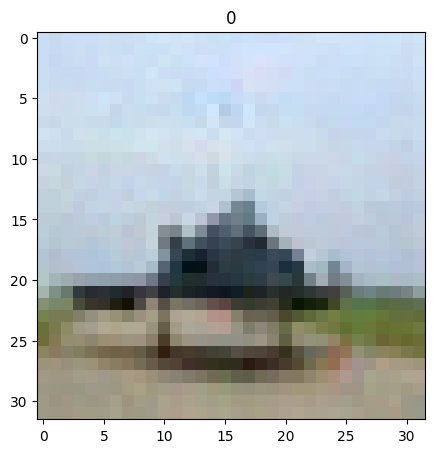

In [6]:
imshow(images_cw_base[0][idx], title=images_cw_base[1][idx].item())

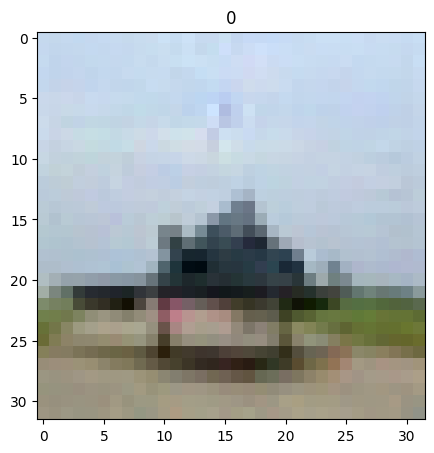

In [7]:

imshow(images_cw_rbf[0][idx], title=images_cw_rbf[1][idx].item())

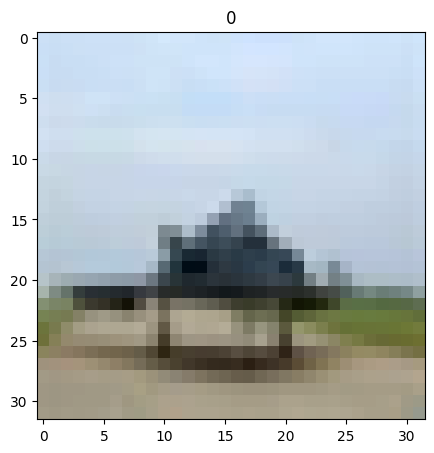

In [8]:
imshow(images_benign_base[0][idx], title=images_benign_base[1][idx].item())

# Analyze ReLUs

In [9]:
def load_data(path, label):
    with open(path, 'rb') as iffile:
        features = pickle.load(iffile)
    layer = 'flatten'
    features = features[layer]
    features_matrix = None

    for i in range(len(features)):
        if isinstance(features_matrix, torch.Tensor):
            features_matrix = torch.cat((   features_matrix, features[i]))
        else:
            features_matrix = features[i]

    features = None    
    features_matrix = torch.flatten(features_matrix, start_dim=1, end_dim=-1)
    y = np.empty(features_matrix.shape[0])
    y.fill(label)
    return [features_matrix, y]

In [10]:
features_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_d2a45a4dd02a5e037e5954b82387e666/ReLUs/ReLUs_CW_test_adversarial_2560_integrated-True.pkl"

features = load_data(features_path, -1)

### Indeed, the features are RELUd

#### TODO - which version of resnet are they using?

# Compute pixel-wise metrics


In [11]:
import torch.nn as nn

In [12]:
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()

In [13]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign_base[0]))
print("Mean per-pixel difference between CW base and benign images is : ", l2_loss_base.item())

Mean per-pixel difference between CW base and benign images is :  5.5998596508288756e-05


In [14]:
l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign_base[0]))
print("Mean per-pixel difference between CW base and benign images is : ", l2_loss_rbf.item())

Mean per-pixel difference between CW base and benign images is :  4.982640894013457e-05
